### ライブラリの準備

###モジュールのインポート

In [1]:
import os
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import datetime
#from tqdm import tqdm
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from collections import deque
from typing import Sequence, Dict, Tuple, Union

import torch
from torch import nn
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import torchvision.datasets as dataset
from torchvision.transforms import v2
import torchvision.transforms as T
from torch.nn.init import constant_, xavier_uniform_, kaiming_uniform_, xavier_normal_, kaiming_normal_

from transformers import  CLIPVisionModel, get_linear_schedule_with_warmup, BertTokenizer, BertForMaskedLM

import util
import levenshtein
from nltk import bleu_score
#from cidereval import cider, ciderD

In [2]:
class PositionalEmbedding(nn.Module):
    '''
    位置埋め込み （Positional embedding）
    dim_embedding: 埋込み次元
    max_len      : 入力の最大系列長
    '''
    def __init__(self, dim_embedding: int, max_len: int=2048):
        super().__init__()

        self.pos_emb = nn.Embedding(max_len, dim_embedding)

    '''
    位置エンコーディングの順伝播
    x: 位置エンコーディングを埋め込む対象のテンソル,
       [バッチサイズ, 系列長, 埋め込み次元]
    '''
    def forward(self, x: torch.Tensor):
        seq = x.shape[1]
        #positions = torch.arange(start=0, end=seq, step=1, device=x.device, requires_grad = False ).to(torch.long)
        positions = torch.arange(start=0, end=seq, step=1, device=x.device ).to(torch.long)
        positions = self.pos_emb(positions)[:seq,:]
        
        return positions

### CaptioningTransformer

In [3]:
class CaptioningTransformer(nn.Module):
    '''
    CaptioningTransformerのコンストラクタ
    dim_embedding  : 埋め込み次元
    dim_feedforward: FNNの中間特徴次元
    num_heads      : マルチヘッドアテンションのヘッド数
    num_layers     : Transformerデコーダ層の数
    vocab_size     : 辞書の次元
    null_index     : NULLのID
    dropout        : ドロップアウト確率
    '''
    def __init__(self, img_size: int, length_max: int, dim_embedding: int, num_heads: int, 
                 prop_dec_num_layers: int, aux_dec_num_layers: int, vocab_size: int, tokenizer,
                 dropout: float = 0.1, pad_token_id: int=0):
        super().__init__()

        #CLIP
        model_id = "openai/clip-vit-large-patch14-336"
        self.clip_model = CLIPVisionModel.from_pretrained(model_id, output_hidden_states = True)
        images = torch.randn( ( 1, 3, img_size, img_size ) )
        memory = self.clip_model( images )
        memory = memory.last_hidden_state
        img_length = memory.size(1)
        clip_dim = memory.size(2)
        
        # Dense Connector

        self.dc_linear = nn.Linear( clip_dim * 3, dim_embedding )
        self.dropout = nn.Dropout( dropout )        
        self.ln_memory = nn.LayerNorm( dim_embedding )

        # Down Sampling
        stride = img_length // ( length_max - 1 )
        self.conv1 = nn.Conv1d( dim_embedding, dim_embedding, 1, stride )
        print( "img_length:", img_length )
        print( "text_length_max:", length_max )
        print( "stride:", stride )
        tgt = self.conv1( memory.transpose(1,2) ).transpose(1,2)
        print( "tgt size:", tgt.size() )

        
        # proper decoder
        self.prop_decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, norm_first = True, activation='gelu')
            for _ in range(prop_dec_num_layers)
        ])

        self.prop_ln = nn.LayerNorm( dim_embedding )
        # 単語出力分布計算
        self.prop_linear = nn.Linear(dim_embedding, vocab_size)        

        # Word Embeidding
        #self.emb = nn.Embedding( vocab_size, dim_embedding, padding_idx = tokenizer.pad_token_id )
        # Word Embeidding
        self.emb = nn.Embedding( vocab_size, dim_embedding )
        
        ## 位置エンコーディング
        self.pos_emb = PositionalEmbedding(dim_embedding)
        
        #dropout
        self.dropout = nn.Dropout( dropout )
        
        # aux decoder
        self.aux_decoder_layers = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=dim_embedding, nhead=num_heads, batch_first=True, norm_first = True, activation='gelu')
            for _ in range(aux_dec_num_layers)
        ])

        self.aux_ln = nn.LayerNorm( dim_embedding )
        # 単語出力分布計算
        self.aux_linear = nn.Linear(dim_embedding, vocab_size)        
        
        # Others
        self.dim_embedding = dim_embedding
        self.tokenizer = tokenizer
        self.pad_token_id = pad_token_id
        self._reset_parameters(self)

    def _reset_parameters(self, model ):
        for name, module in model.named_modules():
            #print("name:",name)
            if "clip_model" not in name and "prop_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
            elif "clip_model" not in name and "aux_decoder" in name:
                if isinstance( module, nn.Linear ):
                    #print("name1:", name )
                    for name, p in module.named_parameters():
                        xavier_uniform_(module.weight)
                        nn.init.zeros_(module.bias)
                        #if name == "weight":
                            #print( "name2:", name)
                            #xavier_uniform_(p)
                            #xavier_normal_(p)
                            #kaiming_uniform_(p)
                            #kaiming_normal_(p)
                            #nn.init.normal_(p, mean=0.0, std=0.02)
                        #elif name == "bias":
                        #    nn.init.zeros_(p)
                elif isinstance( module, nn.Embedding):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                elif isinstance(module, nn.LayerNorm):
                    nn.init.zeros_(module.bias)
                    nn.init.ones_(module.weight)  
    
            #if isinstance(module, nn.Linear):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #    if module.bias is not None:
            #        nn.init.zeros_(module.bias)
            #elif isinstance(module, nn.Embedding):
            #    nn.init.normal_(module.weight, mean=0.0, std=0.02)
            #elif isinstance(module, nn.LayerNorm):
            #    nn.init.zeros_(module.bias)
            #    nn.init.ones_(module.weight)  

    ''' CaptioningTransformerの順伝播処理
    features: 画像特徴量 [バッチサイズ, 埋め込み次元]
    captions: 正解キャプション [バッチサイズ, 系列長]
    '''
    def forward(self, images: torch.Tensor, captions: torch.Tensor ):

        self.device = images.device

        memory = self.clip_model( images )
        memory = self.dense_connector( memory )
        memory = self.dropout( memory )
        memory = self.ln_memory( memory )
        aux_memory = memory # cross entropy 計算のため

        tgt = self.conv1( memory.transpose(1,2) ).transpose(1,2)
        
        # ctc loss 計算のため
        for layer in self.prop_decoder_layers:
            tgt = layer( tgt, memory, tgt_mask = None, tgt_key_padding_mask = None, 
                       memory_key_padding_mask = None, tgt_is_causal = False ) 
            
            
        # 単語出力分布計算
        tgt = self.prop_ln( tgt )
        prop_logits = self.prop_linear( tgt )

        # cross entropy 計算のため    
        aux_tgt = self.emb( captions ) * math.sqrt(self.dim_embedding)
        
        position = self.pos_emb( aux_tgt )
        aux_tgt += position

        #dropout
        aux_tgt = self.dropout( aux_tgt )        
            
        #aux_tgt_key_padding_mask = torch.eq( captions, self.pad_token_id )
        aux_tgt_key_padding_mask = None
        #aux_tgt_mask = nn.Transformer.generate_square_subsequent_mask( captions.size(1), dtype=bool, device=self.device )
        aux_tgt_mask = None
        
        for layer in self.aux_decoder_layers:
            aux_tgt = layer( aux_tgt, aux_memory, tgt_mask = aux_tgt_mask, tgt_key_padding_mask = aux_tgt_key_padding_mask, 
                       memory_key_padding_mask = None, tgt_is_causal = False )        
                       #memory_key_padding_mask = None, tgt_is_causal = True )        
        # 単語出力分布計算
        aux_tgt = self.aux_ln( aux_tgt )
        aux_logits = self.aux_linear( aux_tgt )
            
        return prop_logits, aux_logits

    def dense_connector(self, memory ):
        tmp1 = torch.tensor([], device = self.device  )
        tmp2 = torch.tensor([], device = self.device  )
        tmp_full = len( memory.hidden_states )
        tmp_half = tmp_full // 2
        for i in range( 0, tmp_half ):
            tmp1 = torch.cat( [tmp1, memory.hidden_states[i][None]], dim = 0 )
        tmp1 = torch.sum(tmp1, dim=0) / tmp_half
        for i in range( tmp_half, tmp_full ):
            tmp2 = torch.cat( [tmp2, memory.hidden_states[i][None]], dim = 0 )
        tmp2 = torch.sum(tmp2, dim=0 ) / ( tmp_full - tmp_half )
        tmp3 = torch.cat([tmp1, tmp2], dim=-1)
        tmp3 = torch.cat( [ memory.last_hidden_state, tmp3], dim = -1 )
        #tmp3 = sel.dc_ln( tmp3 )
        tmp3 = self.dc_linear( tmp3 )
        return tmp3

In [4]:
class MyDataset(Dataset):
    def __init__(self, file_path: str, img_directory: str, transforms, tokenizer, length_max = None ) -> None:
        super().__init__()
        self.img_directory = img_directory
        self.transforms = transforms
        # TODO: fix to original data
        #画像の前処理
        self.img_file = []
        self.tokens = []
        #vocab_size = len( tokenizer )
        #c1 = torch.zeros( ( vocab_size ) )
        #c2 = torch.zeros( ( vocab_size, vocab_size ) )
        if length_max == None:
            self.length_max = 0
        else:
            self.length_max = length_max
        length_sum = 0

        with open( file_path, 'rb') as f:
            data = pickle.load(f)
        for i, line_data in enumerate( data ):
            if i % 100000 == 0:
                print( "i:", i )
            self.img_file.append( line_data['img_file'] )
            id_tokens = line_data['id_tokens']
            length_sum += len( id_tokens )
            if length_max != None:
                id_tokens = torch.tensor( id_tokens )[:self.length_max]
            else:
                if self.length_max < len( id_tokens ):
                    self.length_max = len( id_tokens )
                id_tokens = torch.tensor( id_tokens )
            self.tokens.append( id_tokens )
        # w1, w2 を作る時は length_max = None　でお願いします。
        #    for i2 in range( len(id_tokens) ):
        #        if i2 == len( id_tokens ) - 1:
        #            c1[id_tokens[i2]] += 1
        #        else:
        #            c1[id_tokens[i2]] += 1
        #            c2[id_tokens[i2], id_tokens[i2+1] ] += 1
        '''
        c1avg = int( torch.sum( c1 ) / torch.sum( torch.ne( c1, 0 ).int()) )
        c2avg = int( torch.sum( torch.sum( c2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( c2, 0 ).int() ) )

        c1[0] = c1avg

        c2[:,0] = c2avg
        c2[0,:] = c2avg
        
        sumc1 = torch.sum( c1, dim = 0 )
        sumc2 = torch.sum( torch.sum( c2, dim = 1 ), dim = 0 )

        prob1 = c1 / sumc1
        prob2 = c2 / sumc2

        self.w1 = prob1 ** -0.4
        self.w1 = torch.nan_to_num( self.w1, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg1 = torch.sum( self.w1, dim = 0 ) / torch.sum( torch.ne( self.w1, 0.0 ).int() )
        self.w1 = self.w1 / avg1

        self.w2 = prob2 ** -0.4
        self.w2 = torch.nan_to_num( self.w2, nan = 0.0, posinf=0.0, neginf=0.0 )
        avg2 = torch.sum( torch.sum( self.w2, dim = 1 ), dim = 0 ) / torch.sum( torch.ne( self.w2, 0.0 ).int() )
        self.w2 = self.w2 / avg2

        with open( "/mnt/ssd2/v7/w_unigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w1, f )

        with open( "/mnt/ssd2/v7/w_bigrma.pkl", mode="wb" ) as f:
            pickle.dump( self.w2, f )
        
        '''

        #with open( "/mnt/ssd2/v7/w_unigram.pkl", 'rb') as f:
        #    self.w1 = pickle.load(f)

        #with open( "/mnt/ssd2/v7/w_bigram.pkl", 'rb') as f:
        #    self.w2 = pickle.load(f)
        
        if length_max == None:
            print( "length max:", self.length_max )
            print( "avg length:", length_sum / len( self.tokens ) )
    
    # ここで取り出すデータを指定している
    def __getitem__(
        self,
        index: int
    ):
        tokens = self.tokens[index]
        img_file = self.img_file[index] + ".jpg"
        img_path = os.path.join( self.img_directory, img_file ) #index番目の画像のパスを取得
        img = Image.open(img_path) #PIL形式で画像を読み込み
        if img.mode != 'RGB':
            img = img.convert("RGB")
        img = self.transforms(img)
        
        return img, tokens

    # この method がないと DataLoader を呼び出す際にエラーを吐かれる
    def __len__(self) -> int:
        return len(self.tokens)

    def length_max(self):
        return self.length_max

    #def w1(self):
    #    return self.w1

    #def w2(self):
    #    return self.w2

In [5]:
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]], pad_index, length_max ):
    imgs, tokens = zip(*batch)

    max_length = length_max
    #max_length = 0
    #for target in tokens:
    #    if max_length < len( target ):
    #        max_length = len( target )
    
    targets = []
    lengths = []
    for target in tokens:
        pad_len = max_length - len( target ) 
        #print( "target:", target )
        input2= F.pad( target, (0, pad_len), mode='constant', value = pad_index)
        targets.append( input2 )
        lengths.append( len( target ) )
    
    imgs = torch.stack( imgs, dim = 0 )
    targets = torch.stack( targets, dim = 0 )
    lengths = torch.tensor( lengths, requires_grad = False  )

    #if imgs.dim() != 4:
    #   print( "in collate imgs size:", imgs.size() )
    
    return imgs, targets, lengths

In [6]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )


caption = "Hello World!".lower()
token_ids = tokenizer.encode( caption )
print( token_ids )
#decoded = tokenizer.tokenize( token_ids )
#print( decoded )
decoded = tokenizer.decode( token_ids )
print( decoded )
#print( tokenizer.tokenize( decoded ) )
#individual_decoded_tokens = list(map(tokenizer.decode, token_ids))
individual_decoded_tokens = [tokenizer.decode( [token], skip_special_tokens = True ) for token in token_ids ]
individual_decoded_tokens2 = [tokens for tokens in individual_decoded_tokens if tokens != '' ]
print( individual_decoded_tokens2 )

blank token_id: 1
[101, 7592, 2088, 999, 102]
[CLS] hello world! [SEP]
['hello', 'world', '!']


blank  token_id: 1


Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
train_dataset.length_max: 97
torch.Size([4, 97])
torch.Size([4, 3, 336, 336])


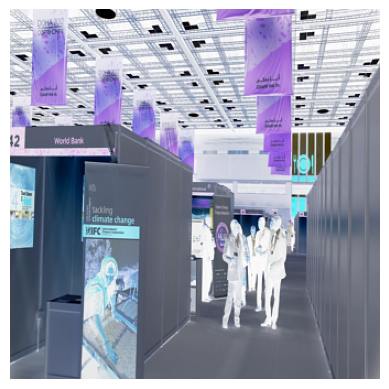

In [8]:
device = torch.device( 'cpu' )
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank  token_id:", blank_token_id )
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id)

#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#kd_model = BertForMaskedLM.from_pretrained(pretrained_model_name_or_path = path).to(config.device)
model_id = "google-bert/bert-large-uncased"
kd_model = BertForMaskedLM.from_pretrained(model_id).to(device)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((336, 336)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# 画像のtransformsを定義
#transforms = T.Compose([
#    T.Resize((336, 336)),
#    T.RandomHorizontalFlip(),
#    T.ToTensor(),
#    # ImageNetデータセットの平均と標準偏差
#    T.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
#])


# v7 データセット
train_dataset = MyDataset( file_path="/mnt/ssd2/v7/data.pkl",
                           img_directory = "/mnt/ssd2/v7/img",
                           #img_directory = "smb://192.168.1.2/img/v7/",
                           transforms=transforms, tokenizer = tokenizer, length_max = 97 )

print( "train_dataset.length_max:", train_dataset.length_max )

# Subset samplerの生成
#val_set, train_set = util.generate_subset(
#    train_dataset, config.val_ratio)
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, 0.1, 0.1 )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id, length_max = 97 )
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=4,
                    num_workers=0,
                    shuffle = False,
                    #sampler=train_sampler,
                    pin_memory = True,
                    collate_fn=collate_func_lambda)
transforms_inv = v2.Compose([
    v2.Normalize((-0.48145466/0.26862954, -0.4578275/0.26130258, -0.40821073/0.27577711), (1/0.26862954,1/0.26130258,1/0.27577711)),
    v2.ToPILImage()
])


#for n, (imgs, targets, lengths) in enumerate( train_loader ):
#    #print( "imgs size:", imgs.size())
#    if n % 100 == 0:
#        print( "n:", n )
    
imgs, targets, lengths = next(iter(train_loader))

##print( targets )
print( targets.size() )
print( imgs.size() )
##print( imgs[0] )
##img[0].show()
inv_img = transforms_inv( imgs[0] )
plt.imshow( inv_img )
plt.axis('off')
plt.show()

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、システム共通変数の設定
    '''
    def __init__(self):

        # ハイパーパラメータ
        #self.clip_dim = 1024
        self.img_size = 336
        self.dim_embedding = 1024   # 埋め込み層の次元
        self.num_heads = 16
        #self.num_heads = 20
        #self.prop_dec_num_layers = 12
        self.prop_dec_num_layers = 24
        #self.aux_dec_num_layers = 12
        self.aux_dec_num_layers = 24
        self.length_max = 97
        #self.lr = 5e-5            # 学習率
        #self.lr = 2e-5            # 学習率
        #self.lr = 1e-5            # 学習率
        #self.lr = 2e-6            # 学習率
        #self.lr = 1e-6            # 学習率
        #self.lr = 5e-7            # 学習率
        #self.lr_clip = 2e-7            # 学習率
        self.lr_clip = 2e-7            # 学習率
        self.lr_prop_decoder = 1e-4            # 学習率
        self.lr_aux_decoder = 1e-4            # 学習率
        self.lr_others = 1e-4
        self.dropout = 0.1
        #self.batch_size = 128       # ミニバッチ数
        self.batch_size = 24       # ミニバッチ数
        #self.batch_size = 16       # ミニバッチ数
        #self.batch_size = 12       # ミニバッチ数
        #self.batch_size = 8       # ミニバッチ数
        #self.batch_size = 6       # ミニバッチ数
        #self.batch_size = 4       # ミニバッチ数
        #self.batch_size = 2       # ミニバッチ数
        #self.batch_size = 1       # ミニバッチ数
        #self.num_epochs = 100       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 60       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.num_epochs = 10       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        #self.num_epochs = 5       # エポック数→Colab無料版でテストする際は10未満に修正を推奨
        self.use_amp = True
        #self.use_amp = False
        #self.use_saved_pth = True
        self.use_saved_pth = False
        self.vocab_size = len( tokenizer )
        self.alpha = 0.01
        self.T = 3.0
        self.weight_decay = 0.1
        self.betas = (0.9, 0.999 )
        self.warmup = 0.1

        # パスの設定
        self.img_directory = '/mnt/ssd2/v7/img'
        self.anno_file = '/mnt/ssd2/v7/data.pkl'
        self.save_directory = './model'

        # 検証に使う学習セット内のデータの割合
        self.test_ratio = 0.1
        self.val_ratio = 0.1
        #self.val_ratio = 0.0004
        #self.test_ratio = 0.0004
        
        # 学習に使うデバイス
        #self.device = 'cuda'
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.device = 'cpu'
        
        # データローダーに使うCPUプロセスの数
        #self.num_workers = 4
        self.num_workers = 0 if self.device == torch.device('cpu') else 12
        #self.num_workers = 0 if self.device == torch.device('cpu') else 6
        #self.num_workers = 0
        
        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

In [10]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )
model = CaptioningTransformer( img_size = 336, length_max = train_dataset.length_max, dim_embedding=1024, num_heads = 16, \
                               prop_dec_num_layers = 24, aux_dec_num_layers=24, vocab_size=len(tokenizer),tokenizer=tokenizer, \
                               dropout = 0.1, pad_token_id = tokenizer.pad_token_id ).to(device)
images = torch.randn( ( 2, 3, 336,336 ), device = device )
captions = torch.randint( 0, len(tokenizer), size=( 2, 50  ), device = device )
prop_logits, aux_logits = model( images, captions[:,:-1] )

print( prop_logits.size() )
print( aux_logits.size() )

blank token_id: 1
img_length: 577
text_length_max: 97
stride: 6
tgt size: torch.Size([1, 97, 1024])
torch.Size([24, 2, 97, 30522])
torch.Size([2, 49, 30522])


In [7]:
def ctc_simple_decode(int_vector, tokenizer):
    ''' 以下の手順で，フレーム単位のCTC出力をトークン列に変換する
        1. 同じ文字が連続して出現する場合は削除
        2. blank を削除
    int_vector: フレーム単位のCTC出力(整数値列)
    token_list: トークンリスト
    output:     トークン列
    '''
    # 出力文字列
    output = []
    # 一つ前フレームの文字番号
    prev_token = -1
    # フレーム毎の出力文字系列を前から順番にチェックしていく
    for n in int_vector:
        n = n.item()
        if n != prev_token:
            # 1. 前フレームと同じトークンではない
            if n != tokenizer.encode( [ "[unused0]"] )[1] and n != tokenizer.encode( [ "[CLS]"] )[1] \
                and n != tokenizer.encode( [ "[SEP]"] )[1] and n != tokenizer.encode( [ "[PAD]"] )[1]:
                # 2. かつ，blank(番号=0)ではない
                # --> token_listから対応する文字を抽出し，
                #     出力文字列に加える
                output.append( tokenizer.decode( [n] ) )
            # 前フレームのトークンを更新
            prev_token = n
        if n == tokenizer.encode( ["[SEP]"] )[1]:
            break
    return output

### 学習を行う

In [ ]:
#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = path)
model_id = "google-bert/bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(model_id)
blank_token_id = tokenizer.encode( [ "[unused0]"] )[1]
print( "blank token_id:", blank_token_id )

config = ConfigTrain()

print( "use_amp:", config.use_amp )

#path = "../CLIP_ENCODER/models--google-bert--bert-large-uncased/snapshots/6da4b6a26a1877e173fca3225479512db81a5e5b"
#kd_model = BertForMaskedLM.from_pretrained(pretrained_model_name_or_path = path).to(config.device)
model_id = "google-bert/bert-large-uncased"
kd_model = BertForMaskedLM.from_pretrained(model_id).to(config.device)

# モデル出力用のディレクトリを作成
os.makedirs(config.save_directory, exist_ok=True)

# 画像のtransformsを定義
transforms = v2.Compose([
    v2.Resize((config.img_size, config.img_size)),
    #v2.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.AutoAugment(),
    ## Coco データセット 2017 train の平均と標準偏差
    #v2.Normalize((0.456,0.427,0.401),(0.224,0.219,0.231) )
    # Clip Model の config から引用。
    v2.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])

# v7 データセット
train_dataset = MyDataset( file_path=config.anno_file,
                           img_directory = config.img_directory,
                           transforms=transforms,tokenizer=tokenizer, length_max = config.length_max)

# Subset samplerの生成
test_set, val_set, train_set = util.generate_subset_test_val_train(
    train_dataset, config.test_ratio, config.val_ratio )
    
# 学習時にランダムにサンプルするためのサンプラー
train_sampler = SubsetRandomSampler(train_set)

# DataLoaderを生成
collate_func_lambda = lambda x: collate_func(x, tokenizer.pad_token_id, config.length_max)
train_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=train_sampler,
                    collate_fn=collate_func_lambda)

val_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=config.batch_size,
                    num_workers=config.num_workers,
                    sampler=val_set,
                    collate_fn=collate_func_lambda)

test_loader = torch.utils.data.DataLoader(
                    train_dataset,
                    #batch_size=config.batch_size,
                    batch_size=1,
                    num_workers=config.num_workers,
                    sampler=test_set,
                    collate_fn=collate_func_lambda)


print( "device:", config.device )
print( "学習セット数:",len( train_loader ) )
print( "評価セット数:",len( val_loader ))
print( "テストセット数:",len( test_loader ))
    
# モデルの定義
model = CaptioningTransformer( config.img_size, config.length_max, config.dim_embedding, config.num_heads, 
                               config.prop_dec_num_layers, config.aux_dec_num_layers, 
                               len(tokenizer), tokenizer, config.dropout, tokenizer.pad_token_id)
model = model.to(config.device) 

# 損失関数の定義
ctc_criterion = nn.CTCLoss(blank=blank_token_id, reduction='mean',zero_infinity=True) 
#ce_criterion = nn.CrossEntropyLoss( ignore_index = tokenizer.pad_token_id, reduction = 'mean' )
#ce_criterion = nn.CrossEntropyLoss( reduction = 'mean' )


# 最適化手法の定義
# Optimizerの生成, clipとそうでないモジュールとの
# パラメータで異なる学習率を適用
params_clip = []
params_prop_decoder = []
params_aux_decoder = []
params_others = []
for name, parameter in model.named_parameters():
    if parameter.requires_grad:
        if 'clip_model' in name:
            params_clip.append(parameter)
        elif 'prop_decoder' in name:
            params_prop_decoder.append(parameter)
        elif 'aux_decoder'in name:
            params_aux_decoder.append(parameter)
        else:
            params_others.append(parameter)
param_groups = [
    {'params': params_clip, 'lr': config.lr_clip},
    {'params': params_prop_decoder, 'lr': config.lr_prop_decoder},
    {'params': params_aux_decoder, 'lr': config.lr_aux_decoder},
    {'params': params_others, 'lr': config.lr_others}]
optimizer = torch.optim.AdamW( param_groups, weight_decay = config.weight_decay, betas=config.betas )

# 全ステップ数
num_global_steps = len( train_loader ) * config.num_epochs
print( "num_global_steps:", num_global_steps )
num_warmup_steps = num_global_steps * 0.1
print( "num_warmup_steps:", num_warmup_steps )
#スケジューラーの定義
scheduler = get_linear_schedule_with_warmup( optimizer, num_warmup_steps, num_global_steps )    

PATH = f'{config.save_directory}/model_clip_decoder2_kd_nar_curr.pth'
print( "use_saved_pth:", config.use_saved_pth )
print( "exist saved_pth:", os.path.isfile(PATH) ) 
if config.use_saved_pth and os.path.isfile(PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    ##device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    ## optimizerのstateを現在のdeviceに移す。これをしないと、保存前後でdeviceの不整合が起こる可能性がある。
    #for state in optimizer.state.values():
        #for k, v in state.items():
            #if isinstance(v, torch.Tensor):
                #state[k] = v.to(device)
    begin_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    global_step = checkpoint['global_step']
else:
    begin_epoch = 0
    global_step = 0

print( "begin_epoch:", begin_epoch )
print( "global_step:", global_step )
    
len_tr_loader = len( train_loader )
train_param = len_tr_loader // 10
len_val_loader = len( val_loader )
#train_param = len_val_loader // 3
val_param = len_val_loader // 3
print( "train_param:", train_param )
print( "val_param:", val_param )

print( "epochs:", config.num_epochs )
print( "batch_size:", config.batch_size )
print( "lr_clip:", config.lr_clip )
print( "lr_prop_decoder:", config.lr_prop_decoder )
print( "lr_aux_decoder:", config.lr_aux_decoder )
print( "lr_others:", config.lr_others )
print( "weight_decay:", config.weight_decay )
print( "betas:", config.betas )
print( "alpha:", config.alpha )
print( "T:", config.T )

# 学習経過の書き込み
now = datetime.datetime.now()
train_loss_file = '{}/MyOriginal_train_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(train_loss_file, 'a') as f:
    print(f'{len_tr_loader}', file=f)
print( "train_loss_file:", train_loss_file )
val_loss_file = '{}/MyOriginal_val_loss_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
with open(val_loss_file, 'a') as f:
    print(f'{len_val_loader}', file=f) 
norm_file = '{}/norm_{}.csv'\
    .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

# 学習
val_loss_best = float('inf')

fn = bleu_score.SmoothingFunction().method7

# AMP用のスケーラー
scaler = GradScaler(enabled=config.use_amp)

for epoch in range(begin_epoch, config.num_epochs):
    with tqdm(train_loader) as pbar:
    #with tqdm(val_loader) as pbar:
        pbar.set_description(f'[エポック {epoch + 1}]')

        # 学習モードに設定
        model.train()

        train_losses = deque()
        a1 = deque()
        b1 = deque()
        train_errors = deque()
        train_bleus = deque()
        #train_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):
            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            caption_lengths = caption_lengths.to(config.device)
                
            optimizer.zero_grad()

            with autocast(str(config.device),enabled=config.use_amp):
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                ctc_logits, ce_logits = model(imgs, captions )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )
                
                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                ctc_loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)
                with torch.no_grad():
                    kd_model.eval()
                    #attention_mask = None
                    #kd_logits = kd_model( input_ids = captions, attention_mask = attention_mask )[0]
                    kd_logits = kd_model( input_ids = captions )[0]
                kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(ce_logits/config.T, dim=-1),F.softmax(kd_logits/config.T, dim=-1)) * ( config.T * config.T )
                a = ctc_loss
                b = config.alpha * kd_loss
                loss =  a + b

            # 誤差逆伝播
            scaler.scale(loss).backward()
            #scaler.unscale_(optimizer)
            #clip_grad_threshold = 5.0
            #torch.nn.utils.clip_grad_norm_(\
            #        model.parameters(),
            #        clip_grad_threshold)
            # オプティマイザにより，パラメータを更新する
            scaler.step(optimizer)
            scaler.update()            
            
            scheduler.step()

            #for name, param in model.named_parameters():
            #    print( name )
            # 勾配消失が起こっていないか監視
            norm0 = torch.sqrt( torch.norm( model.clip_model.vision_model.encoder.layers[0].self_attn.q_proj.weight.grad, p = 2 ) ).item()
            norm1 = torch.sqrt( torch.norm( model.prop_decoder_layers[23].self_attn.in_proj_weight.grad, p = 2 ) ).item()
            norm_mean = torch.mean( torch.stack ([ torch.sqrt( torch.norm( param.grad, p = 2 ) ) \
                                                  for param in model.parameters() if param.grad is not None ] ) ).item()
            with open(norm_file, 'a') as f:
                print( "epcoch:", epoch, ", step:", global_step, ", norm0:", norm0, ", norm1:", norm1, ", norm_mean:", norm_mean, file=f  )
                f.flush()
            global_step += 1

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for n3, (hypo_id, caption) in enumerate( zip( hypo_ids, captions )):
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )
                
                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens,ref_tokens)
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                
                if n < 1 and n_batch == len( train_loader ) - 1 :
                #if n < 1 and n_batch == len( val_loader ) - 1 :
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                if n < 1 and n_batch % train_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
            
            avg_error = total_error / total_token_length * 100
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2
            
            # 学習時の損失をログに書き込み
            train_losses.append(loss.item())
            a1.append(a.item())
            b1.append(b.item())
            train_errors.append( avg_error )
            train_bleus.append( avg_bleu )
            #train_ciders.append( avg_cider )
            if len(train_losses) > config.moving_avg:
                train_losses.popleft()
                a1.popleft()
                b1.popleft()
                train_errors.popleft()
                train_bleus.popleft()
                #train_ciders.popleft()
            mean_loss = torch.Tensor(train_losses).mean().item()
            mean_a1 = torch.Tensor(a1).mean().item()
            mean_b1 = torch.Tensor(b1).mean().item()
            mean_error = torch.Tensor(train_errors).mean().item()
            mean_bleu = torch.Tensor(train_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'ctc': mean_a1,
                'kd': mean_b1,
                'WER': mean_error,
                'BLEU': mean_bleu,
                #'CIDER': torch.Tensor(train_ciders).mean().item()
            })
            with open(train_loss_file, 'a') as f:
                #print(f'{epoch}, {loss.item()},  {avg_error}, {avg_bleu}, {avg_cider}', file=f)
                print(f'{epoch}, {mean_loss}, {mean_a1}, {mean_b1}, {mean_error}, {mean_bleu}', file=f)
            print_flag = 1
            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                if print_flag == 1:
                    print( "lr_clip  :", optimizer.param_groups[0]["lr"] )
                    print( "lr_prop_decoder:", optimizer.param_groups[1]["lr"] )
                    print( "lr_aux_decoder:", optimizer.param_groups[2]["lr"] )
                    print( "lr_others:", optimizer.param_groups[3]["lr"] )
                    print_flag = 0
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print(f'Train epoch = {epoch}, loss = {mean_loss}, ctc = {mean_a1}, kd = {mean_b1}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Train epoch = {epoch}, loss = {mean_loss}, ctc = {mean_a1}, kd = {mean_b1}, WER = {mean_error}, BLEU = {mean_bleu}')
                #print(f'Train epoch = {epoch}, loss = {loss.item()}, WER = {avg_error}, BLEU = {avg_bleu}, CIDER = {avg_cider}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # 学習率を表示
    print(f"学習率 clip,         param_groups:", optimizer.param_groups[0]["lr"] )
    print(f"学習率 prop_decoder, param_groups:", optimizer.param_groups[1]["lr"] )
    print(f"学習率 aux_decoder,  param_groups:", optimizer.param_groups[2]["lr"] )
    print(f"学習率 others,       param_groups:", optimizer.param_groups[3]["lr"] )
    train_loss = np.mean(train_losses)
    train_error = np.mean(train_errors )
    train_bleu = np.mean(train_bleus )
    #train_cider = np.mean(train_ciders )
    print(f'Train loss: {train_loss}')
    print(f'Train WER: {train_error}')        
    print(f'Train BLEU: {train_bleu}')
    #print(f'Train CIDER: {train_cider}')

    # 検証
    with tqdm(val_loader) as pbar:
        pbar.set_description(f'[検証]')

        # 評価モード
        model.eval()

        val_losses = deque()
        a1 = deque()
        b1 = deque()
        val_errors = deque()
        val_bleus = deque()
        #val_ciders = deque()
        for n_batch, (imgs, captions, caption_lengths) in enumerate( pbar ):

            # ミニバッチを設定
            imgs = imgs.to(config.device)
            captions = captions.to(config.device)
            caption_lengths = caption_lengths.to(config.device)
                
            with torch.no_grad():
                # 最後の単語から次を予測する必要はないため最後の単語を除外
                ctc_logits, ce_logits = model(imgs, captions )
                hypo_ids = torch.argmax( ctc_logits, dim = 2 )
                ctc_outputs_lengths = torch.full( size = (ctc_logits.size(0), ), fill_value = ctc_logits.size(1), dtype=torch.long)
                ctc_outputs = F.log_softmax( ctc_logits, dim=2 )
                
                # 損失の計算
                # 単語軸が第1軸である必要があるため、転置
                ctc_loss = ctc_criterion(ctc_outputs.transpose(0, 1),captions,ctc_outputs_lengths,caption_lengths)
                #attention_mask = (~torch.eq( captions[:,1:], tokenizer.pad_token_id )).float()
                #attention_mask = None
                #kd_logits = kd_model( input_ids = captions, attention_mask = attention_mask )[0]
                kd_model.eval()
                kd_logits = kd_model( input_ids = captions )[0]
                kd_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(ce_logits/config.T, dim=-1),F.softmax(kd_logits/config.T, dim=-1)) * ( config.T * config.T )
                a = ctc_loss
                b = config.alpha * kd_loss
                loss =  a + b

            val_losses.append(loss.item())

            n = 0
            hypo_sentence = []
            ref_sentence = []
            hypo_sentence1 = []
            ref_sentence1 = []
            total_error = 0
            total_token_length = 0
            total_bleu = 0
            #total_cider = 0
            n2 = 0
            for (hypo_id, caption) in zip( hypo_ids, captions ):
                hypo_tokens = ctc_simple_decode(hypo_id, tokenizer)
                hypo = ' '.join( hypo_tokens )
                reference = tokenizer.decode( caption.tolist(), skip_special_tokens = True )
                ref_tokens = tokenizer.tokenize( reference )

                # 認識誤りを計算
                (error, substitute, delete, insert, ref_length) = levenshtein.calculate_error(hypo_tokens, ref_tokens)
                    
                # 誤り文字数を累積する
                total_error += error
                # 文字の総数を累積する
                total_token_length += ref_length

                bleu = bleu_score.sentence_bleu( [reference], hypo, smoothing_function=fn  )
                #cider_ = cider(predictions=[hypo], references=[[reference]])['avg_score']
        
                total_bleu += bleu
                #total_cider += cider_
                #print("hypo:", ' '.join(hypo))

                if n < 1 and n_batch == len( val_loader ) - 1:
                    hypo_sentence.append( hypo )
                    ref_sentence.append( reference )
                        
                if n < 1 and n_batch % val_param == 0:
                    hypo_sentence1.append( hypo )
                    ref_sentence1.append( reference )
                    
                n += 1
                n2 += 1
                
            avg_error = total_error / total_token_length * 100                    
            avg_bleu = total_bleu / n2 * 100
            #avg_cider = total_cider / n2

            # 学習時の損失をログに書き込み
            val_losses.append(loss.item())
            a1.append(a.item())
            b1.append(b.item())
            val_errors.append( avg_error )
            val_bleus.append( avg_bleu )
            if len(val_losses) > config.moving_avg:
                val_losses.popleft()
                a1.popleft()
                b1.popleft()
                val_errors.popleft()
                val_bleus.popleft()
            mean_loss = torch.Tensor(val_losses).mean().item()
            mean_a1 = torch.Tensor(a1).mean().item()
            mean_b1 = torch.Tensor(b1).mean().item()
            mean_error = torch.Tensor(val_errors).mean().item()
            mean_bleu = torch.Tensor(val_bleus).mean().item()
            pbar.set_postfix({
                'loss': mean_loss,
                'ctc': mean_a1,
                'kd': mean_b1,
                'WER': mean_error,
                'BLEU': mean_bleu,
            })
            # Validation Lossをログに書き込み
            with open(val_loss_file, 'a') as f:
                print(f'{epoch}, {mean_loss}, {mean_a1}, {mean_b1},  {mean_error}, {mean_bleu}', file=f)

            for ( hypo_se, ref_se ) in zip( hypo_sentence1, ref_sentence1 ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, ctc = {mean_a1}, kd = {mean_b1}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )
                    
            for ( hypo_se, ref_se ) in zip( hypo_sentence, ref_sentence ):
                print(f'Val epoch = {epoch}, loss = {mean_loss}, ctc = {mean_a1}, kd = {mean_b1}, WER = {mean_error}, BLEU = {mean_bleu}')
                print( "refe:", ref_se )
                print( "hypo:", hypo_se )

    # Loss 表示
    val_loss = np.mean(val_losses)
    val_error = np.mean( val_errors )
    val_bleu = np.mean( val_bleus )
    #val_cider = np.mean( val_ciders )
    print(f'Validation loss: {val_loss}')
    print(f'Validation WER: {val_error}')
    print(f'Validation BLEU: {val_bleu}')
    #print(f'Validation CIDER: {val_cider}')

    # より良い検証結果が得られた場合、モデルを保存
    if val_loss < val_loss_best:
        val_loss_best = val_loss

        # モデルを保存
        torch.save({'epoch': epoch,
                    'global_step': global_step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss,},
            f'{config.save_directory}/model_clip_decoder2_kd_nar_best.pth')
            
    # モデルを保存
    torch.save({'epoch': epoch,
                'global_step': global_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,},
        f'{config.save_directory}/model_clip_decoder2_kd_nar_curr.pth')
        
# モデルを保存
torch.save({'epoch': epoch,
    'global_step': global_step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'loss': loss,},
    f'{config.save_directory}/model_clip_decoder2_kd_nar_final.pth')

blank token_id: 1
use_amp: True


Some weights of the model checkpoint at google-bert/bert-large-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


i: 0
i: 100000
i: 200000
i: 300000
i: 400000
i: 500000
device: cuda:0
学習セット数: 16915
評価セット数: 2115
テストセット数: 50744
img_length: 577
text_length_max: 97
stride: 6
tgt size: torch.Size([1, 97, 1024])
num_global_steps: 169150
num_warmup_steps: 16915.0
use_saved_pth: False
exist saved_pth: False
begin_epoch: 0
global_step: 0
train_param: 1691
val_param: 705
epochs: 10
batch_size: 24
lr_clip: 2e-07
lr_prop_decoder: 0.0001
lr_aux_decoder: 0.0001
lr_others: 0.0001
weight_decay: 0.1
betas: (0.9, 0.999)
alpha: 0.01
T: 3.0
train_loss_file: ./model/MyOriginal_train_loss_20251114_133237.csv


  0%|          | 0/16915 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


lr_clip  : 1.182382500738989e-11
lr_prop_decoder: 5.911912503694945e-09
lr_aux_decoder: 5.911912503694945e-09
lr_others: 5.911912503694945e-09
Train epoch = 0, loss = 42.344573974609375, ctc = 24.633487701416016, kd = 17.71108627319336, WER = 221.36929321289062, BLEU = 13.447647094726562
refe: in this image there are a few people standing. they are smiling. they are wearing identity cards around their neck. at the top there is a ceiling. there are lights to the ceiling.
hypo: ladder navarro psi ladder harlow navarro ##そ anatolia navarro auschwitz [unused295] navarro anatolia harlow [unused295] harlow [unused163] [unused295] harlow cod shoved navarro staple harlow shoved [unused295] harlow ##des [unused163] 家 satisfactory [unused163] dual listening [unused163] [unused466] [unused169] filthy temperance aforementioned lineup ladder filthy listening navarro stephenson ladder harlow ##ক navarro ladder stephenson add navarro add internship harlow navarro loren ladder navarro [unused295] [unu

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 0, loss = 4.0724287033081055, ctc = 3.0411744117736816, kd = 1.0312541723251343, WER = 75.07660675048828, BLEU = 20.742305755615234
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants . the there can sky .
Val epoch = 0, loss = 4.267445087432861, ctc = 3.158085346221924, kd = 1.1035199165344238, WER = 76.89879608154297, BLEU = 24.598529815673828
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see a persons . the there can objects .
Val epoch = 0, loss = 4.3048176765441895, ctc = 3.1766486167907715, kd = 1.1120905876159668, WER = 76.7606430053711, BLEU = 24.8397274017334
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbols here.
hypo:

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 1.9999868624166582e-07
lr_prop_decoder: 9.999934312083292e-05
lr_aux_decoder: 9.999934312083292e-05
lr_others: 9.999934312083292e-05
Train epoch = 1, loss = 4.195906162261963, ctc = 3.1824281215667725, kd = 1.0134780406951904, WER = 80.2481918334961, BLEU = 19.939987182617188
refe: in this image there is a dog. in the background we can see a sofa. at the bottom there is floor.
hypo: in this image we can see a dog . the there is sofa .
lr_clip  : 1.9777712089861069e-07
lr_prop_decoder: 9.888856044930535e-05
lr_aux_decoder: 9.888856044930535e-05
lr_others: 9.888856044930535e-05
Train epoch = 1, loss = 4.161035537719727, ctc = 3.1210503578186035, kd = 1.039985179901123, WER = 78.12130737304688, BLEU = 21.463804244995117
refe: there is a lady holding a piece of cake. she is wearing chains and a bracelet. in front of her there is a table with plate, cup, saucer and book. in the back there are many people. there is a hookah. also there is a table with crystal vessels and many othe

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 1, loss = 3.870995283126831, ctc = 2.9938483238220215, kd = 0.8771470189094543, WER = 76.09806060791016, BLEU = 18.00691795349121
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants plants , . the background there are buildings sky .
Val epoch = 1, loss = 4.03493070602417, ctc = 3.072248935699463, kd = 0.9488992094993591, WER = 77.76917266845703, BLEU = 21.764331817626953
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see a persons . the there is wall .
Val epoch = 1, loss = 4.06699800491333, ctc = 3.097968101501465, kd = 0.9631040692329407, WER = 77.83943176269531, BLEU = 21.718952178955078
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christian

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 1.7777646401944362e-07
lr_prop_decoder: 8.888823200972181e-05
lr_aux_decoder: 8.888823200972181e-05
lr_others: 8.888823200972181e-05
Train epoch = 2, loss = 3.782268762588501, ctc = 2.9539456367492676, kd = 0.8283231258392334, WER = 74.3827133178711, BLEU = 21.441181182861328
refe: this is an outside view. here i can see few women wearing t - shirts, shoes and running on the ground. in the background there is a person and also i can see few trees and a shed. at the top of the image i can see the sky.
hypo: in this image can see group people running on the . in the background there are trees sky .
lr_clip  : 1.7555489867638846e-07
lr_prop_decoder: 8.777744933819424e-05
lr_aux_decoder: 8.777744933819424e-05
lr_others: 8.777744933819424e-05
Train epoch = 2, loss = 3.9144585132598877, ctc = 3.066709280014038, kd = 0.8477491736412048, WER = 77.40380096435547, BLEU = 21.87203598022461
refe: in this image we can see boats on the water. in the back there is a bridge. and there are v

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 2, loss = 3.672041416168213, ctc = 2.9482531547546387, kd = 0.7237881422042847, WER = 75.89376831054688, BLEU = 19.84070587158203
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees . the there can sky .
Val epoch = 2, loss = 3.8349547386169434, ctc = 3.0438523292541504, kd = 0.7763069272041321, WER = 76.4729995727539, BLEU = 24.800369262695312
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see plants plants .
Val epoch = 2, loss = 3.8641507625579834, ctc = 3.0728869438171387, kd = 0.7898505926132202, WER = 76.33697509765625, BLEU = 24.860383987426758
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbols here.
hypo: i

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 1.555542417972214e-07
lr_prop_decoder: 7.77771208986107e-05
lr_aux_decoder: 7.77771208986107e-05
lr_others: 7.77771208986107e-05
Train epoch = 3, loss = 3.660691499710083, ctc = 2.926924467086792, kd = 0.7337669730186462, WER = 76.04519653320312, BLEU = 27.64943504333496
refe: in this image we can see a child on the bed and we can see a cloth. at the back we can see the wall.
hypo: in this image can see a girl on the . the is a wall .
lr_clip  : 1.5333267645416626e-07
lr_prop_decoder: 7.666633822708313e-05
lr_aux_decoder: 7.666633822708313e-05
lr_others: 7.666633822708313e-05
Train epoch = 3, loss = 3.752967596054077, ctc = 3.0099844932556152, kd = 0.7429831027984619, WER = 77.0130386352539, BLEU = 22.781452178955078
refe: in this image in the foreground there are few people, at the top there is a roof, on which there is a light, in the middle there is a pillar on the left side a woman wearing a bag, standing on the floor, beside her there is a board on which there is a text

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 3, loss = 3.5449018478393555, ctc = 2.9407596588134766, kd = 0.6041423082351685, WER = 76.50663757324219, BLEU = 18.948104858398438
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees , . the there are sky .
Val epoch = 3, loss = 3.71232008934021, ctc = 3.029233932495117, kd = 0.6757200360298157, WER = 77.4925308227539, BLEU = 22.245437622070312
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image can see there . there is .
Val epoch = 3, loss = 3.744047164916992, ctc = 3.050299882888794, kd = 0.685987114906311, WER = 77.48770141601562, BLEU = 22.608369827270508
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbols here.
hypo: thi

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 1.3333201957499917e-07
lr_prop_decoder: 6.666600978749959e-05
lr_aux_decoder: 6.666600978749959e-05
lr_others: 6.666600978749959e-05
Train epoch = 4, loss = 3.38140869140625, ctc = 2.808441162109375, kd = 0.5729674696922302, WER = 74.36181640625, BLEU = 21.531421661376953
refe: in this image there is a snake, person's legs holding metal rod, there are a few posters of snakes attached to the board.
hypo: in this image can see a snake there is a snake . the there is .
lr_clip  : 1.3111045423194403e-07
lr_prop_decoder: 6.555522711597202e-05
lr_aux_decoder: 6.555522711597202e-05
lr_others: 6.555522711597202e-05
Train epoch = 4, loss = 3.610976219177246, ctc = 2.9438788890838623, kd = 0.6670976877212524, WER = 76.02102661132812, BLEU = 25.271591186523438
refe: in the image it looks like some concert, there is a stage and on the stage there are a group of people playing different music instruments, above them there are beautiful lights attached to the roof and in front of the stag

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 4, loss = 3.5360491275787354, ctc = 2.9431159496307373, kd = 0.5929331183433533, WER = 75.6894760131836, BLEU = 20.55475425720215
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees road . the there can buildings sky .
Val epoch = 4, loss = 3.6971516609191895, ctc = 3.0135998725891113, kd = 0.6708324551582336, WER = 76.14530944824219, BLEU = 25.187026977539062
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see people aquarium .
Val epoch = 4, loss = 3.7277846336364746, ctc = 3.0452756881713867, kd = 0.6814950704574585, WER = 76.27611541748047, BLEU = 24.870445251464844
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity sym

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 1.1110979735277695e-07
lr_prop_decoder: 5.555489867638848e-05
lr_aux_decoder: 5.555489867638848e-05
lr_others: 5.555489867638848e-05
Train epoch = 5, loss = 3.446371078491211, ctc = 2.8514208793640137, kd = 0.594950258731842, WER = 76.11111450195312, BLEU = 24.705047607421875
refe: in this image in the foreground there is one woman, and in the background there is a wall.
hypo: in this image can see a person .
lr_clip  : 1.0888823200972182e-07
lr_prop_decoder: 5.444411600486091e-05
lr_aux_decoder: 5.444411600486091e-05
lr_others: 5.444411600486091e-05
Train epoch = 5, loss = 3.567689895629883, ctc = 2.9461829662323, kd = 0.6215072870254517, WER = 76.45174407958984, BLEU = 24.581008911132812
refe: in this image there are two persons in the vehicle, there are bottles in the holder, poles, a person on the road and the wall.
hypo: in this image we can see two people in the vehicle . bottle . in the background there can wall wall .
lr_clip  : 1.0666666666666666e-07
lr_prop_decoder

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 5, loss = 3.4772937297821045, ctc = 2.9309444427490234, kd = 0.5463493466377258, WER = 75.58733367919922, BLEU = 19.998106002807617
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , trees , . the there can sky .
Val epoch = 5, loss = 3.6200978755950928, ctc = 3.0100977420806885, kd = 0.6031545400619507, WER = 76.43717956542969, BLEU = 24.89583969116211
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see people can people there can plants .
Val epoch = 5, loss = 3.652320623397827, ctc = 3.0335493087768555, kd = 0.6107432842254639, WER = 76.54319763183594, BLEU = 25.042089462280273
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbo

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 8.888757513055473e-08
lr_prop_decoder: 4.4443787565277365e-05
lr_aux_decoder: 4.4443787565277365e-05
lr_others: 4.4443787565277365e-05
Train epoch = 6, loss = 3.4675092697143555, ctc = 2.9163646697998047, kd = 0.551144540309906, WER = 76.9650650024414, BLEU = 22.910503387451172
refe: in this image there is a building having a red brick wall. there is some text painted on it. top of image there is sky.
hypo: in this image we can see a building text the is sky .
lr_clip  : 8.666600978749958e-08
lr_prop_decoder: 4.3333004893749793e-05
lr_aux_decoder: 4.3333004893749793e-05
lr_others: 4.3333004893749793e-05
Train epoch = 6, loss = 3.4348526000976562, ctc = 2.876755475997925, kd = 0.5580971837043762, WER = 75.47921752929688, BLEU = 25.9404296875
refe: in this picture we can see man and woman wore helmet and smiling and riding bicycle on road beside to this we have grass, fence and in background we can see sky, trees.
hypo: in this image see a man riding bicycle . background there

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 6, loss = 3.5697226524353027, ctc = 3.011178970336914, kd = 0.5585436224937439, WER = 75.17875671386719, BLEU = 23.078336715698242
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants are trees , . the there sky .
Val epoch = 6, loss = 3.6160268783569336, ctc = 3.0176665782928467, kd = 0.5860058069229126, WER = 75.70919799804688, BLEU = 27.117639541625977
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see persons plants .
Val epoch = 6, loss = 3.6462390422821045, ctc = 3.0413870811462402, kd = 0.6027111411094666, WER = 75.62150573730469, BLEU = 27.712690353393555
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbols here.
hypo: in thi

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 6.666535290833251e-08
lr_prop_decoder: 3.3332676454166254e-05
lr_aux_decoder: 3.3332676454166254e-05
lr_others: 3.3332676454166254e-05
Train epoch = 7, loss = 3.3972434997558594, ctc = 2.893242835998535, kd = 0.5040007829666138, WER = 72.24576568603516, BLEU = 28.552936553955078
refe: in this image i can see purple and white color flower. back i can see few green color leaves.
hypo: in this image we can see a flower grass .
lr_clip  : 6.444378756527736e-08
lr_prop_decoder: 3.222189378263868e-05
lr_aux_decoder: 3.222189378263868e-05
lr_others: 3.222189378263868e-05
Train epoch = 7, loss = 3.459618330001831, ctc = 2.9078195095062256, kd = 0.5517985820770264, WER = 75.52799987792969, BLEU = 26.728349685668945
refe: in this picture we can see a white cat on a wall. we can see a brown cat on the path. there are leaves, glass objects and a few things.
hypo: in this image we can see two cats on the . there can a plants the wall the there can wall door .
lr_clip  : 6.222222222222221

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 7, loss = 3.541884660720825, ctc = 3.00156307220459, kd = 0.5403216481208801, WER = 75.07660675048828, BLEU = 22.592266082763672
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants , trees , . the there can sky .
Val epoch = 7, loss = 3.6337637901306152, ctc = 3.020897150039673, kd = 0.595488965511322, WER = 76.8267822265625, BLEU = 24.368518829345703
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see plants can people plants .
Val epoch = 7, loss = 3.6638011932373047, ctc = 3.0438454151153564, kd = 0.6097129583358765, WER = 76.84822082519531, BLEU = 24.790124893188477
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see christianity symbols here.
hypo:

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 4.4443130686110284e-08
lr_prop_decoder: 2.2221565343055145e-05
lr_aux_decoder: 2.2221565343055145e-05
lr_others: 2.2221565343055145e-05
Train epoch = 8, loss = 3.6347756385803223, ctc = 3.016937255859375, kd = 0.617838442325592, WER = 77.2211685180664, BLEU = 22.982879638671875
refe: in this image i can see a man standing at left i can see a pole at the back ground i can see a dining table, plate a cloth on the table, a small plant, lamp, a door and a wall.
hypo: in this image can see a man standing . there is chairs and table there chairs , the background there is door wall .
lr_clip  : 4.222156534305514e-08
lr_prop_decoder: 2.1110782671527574e-05
lr_aux_decoder: 2.1110782671527574e-05
lr_others: 2.1110782671527574e-05
Train epoch = 8, loss = 3.3240926265716553, ctc = 2.8154919147491455, kd = 0.5086010694503784, WER = 74.37712860107422, BLEU = 28.691505432128906
refe: in front of the image there are two people sitting. in front of them there are a few people standing. aroun

  0%|          | 0/2115 [00:00<?, ?it/s]

Val epoch = 8, loss = 3.507633686065674, ctc = 3.022029399871826, kd = 0.4856042265892029, WER = 73.03370666503906, BLEU = 27.19194984436035
refe: in this image i can see few trees which are green in color, few flowers which are red in color and in the background i can see a person standing, the road, few vehicles, few buildings, few trees and the sky.
hypo: in this image we can see plants there are trees , . the background there are sky .
Val epoch = 8, loss = 3.6098504066467285, ctc = 3.0399794578552246, kd = 0.5485318899154663, WER = 75.3646469116211, BLEU = 29.22011947631836
refe: in this picture we can see planets, where we can see few people and some objects.
hypo: in this image we can see a people . the there can a plants .
Val epoch = 8, loss = 3.641287326812744, ctc = 3.0722391605377197, kd = 0.5671921968460083, WER = 75.55210876464844, BLEU = 29.048646926879883
refe: in this picture we can see some graves and a memorial, in the background there are some trees, we can see chri

  0%|          | 0/16915 [00:00<?, ?it/s]

lr_clip  : 2.2220908463888067e-08
lr_prop_decoder: 1.1110454231944034e-05
lr_aux_decoder: 1.1110454231944034e-05
lr_others: 1.1110454231944034e-05
Train epoch = 9, loss = 3.2622432708740234, ctc = 2.7453179359436035, kd = 0.5169252157211304, WER = 72.31503295898438, BLEU = 33.06657028198242
refe: in this image there are flowers on a tree, in the background of the image there is a building.
hypo: in this image we can see flowers . in the background there is a building sky .
lr_clip  : 1.9999343120832922e-08
lr_prop_decoder: 9.999671560416462e-06
lr_aux_decoder: 9.999671560416462e-06
lr_others: 9.999671560416462e-06
Train epoch = 9, loss = 3.23276424407959, ctc = 2.7503302097320557, kd = 0.48243415355682373, WER = 73.19985961914062, BLEU = 31.137344360351562
refe: in this picture i can see a person is sitting on the vehicle. the person is wearing helmet. in the background i can see sky, grass, trees and a pole.
hypo: in this image we can see a person riding the vehicle is . in the backgr